In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('resiko_kredit.xlsx')

In [3]:
df.head(20) # menampilkan 20 baris pertama dari data

,ID,Gaji,Persentase_Cicilan
0,1,15.5,25
1,2,4.2,45
2,3,22.0,10
3,4,8.0,35
4,5,12.3,20
5,6,3.5,55
6,7,18.0,15
7,8,6.5,40
8,9,25.0,5
9,10,10.0,30


In [4]:
def trapmf(x, a, b, c, d):
    if x <= a or x >= d:
        return 0.0
    elif b <= x <= c:
        return 1.0
    elif a < x < b:
        return (x - a) / (b - a)
    else:
        return (d - x) / (d - c)

def trimf(x, a, b, c):
    if x <= a or x >= c:
        return 0.0
    elif x == b:
        return 1.0
    elif a < x < b:
        return (x - a) / (b - a)
    else:
        return (c - x) / (c - b)

**LANGKAH FUZIFIKASI**

In [5]:
def fuzzify_gaji(gaji):
    return {
        'rendah': trapmf(gaji, 0, 0, 15, 30),
        'medium': trapmf(gaji, 20, 20, 40, 60),
        'tinggi': trimf(gaji, 50, 70, 85),
        'sangat_tinggi': trapmf(gaji, 75, 90, 100, 100)
    }

def fuzzify_cicilan(cicilan):
    return {
        'kecil': trapmf(cicilan, 0, 0, 20, 35),
        'sedang': trimf(cicilan, 25, 45, 65),
        'besar': trimf(cicilan, 55, 75, 90),
        'sangat_besar': trapmf(cicilan, 80, 90, 100, 100)
    }

In [6]:
def plot_gaji(): # membuat grafik untuk gaji
    x = np.linspace(0, 100, 500)

    rendah = [trapmf(i, 0, 0, 15, 30) for i in x]
    medium = [trimf(i, 20, 40, 60) for i in x]
    tinggi = [trimf(i, 50, 70, 85) for i in x]
    sangat_tinggi = [trapmf(i, 75, 90, 100, 100) for i in x]

    plt.figure(figsize=(8, 5))
    plt.plot(x, rendah, label='Rendah')
    plt.plot(x, medium, label='Medium')
    plt.plot(x, tinggi, label='Tinggi')
    plt.plot(x, sangat_tinggi, label='Sangat Tinggi')

    plt.xlabel('Gaji (juta)')
    plt.ylabel('μ')
    plt.title('Gaji')
    plt.legend()
    plt.grid(True)
    plt.show()

In [7]:
def plot_cicilan(): # membuat grafik untuk cicilan
    x = np.linspace(0, 100, 500)

    kecil = [trapmf(i, 0, 0, 20, 35) for i in x]
    sedang = [trimf(i, 25, 45, 65) for i in x]
    besar = [trimf(i, 55, 75, 90) for i in x]
    sangat_besar = [trapmf(i, 80, 90, 100, 100) for i in x]

    plt.figure(figsize=(8, 5))
    plt.plot(x, kecil, label='Kecil')
    plt.plot(x, sedang, label='Sedang')
    plt.plot(x, besar, label='Besar')
    plt.plot(x, sangat_besar, label='Sangat Besar')

    plt.xlabel('Persentase Cicilan (%)')
    plt.ylabel('μ')
    plt.title('Persentase Cicilan')
    plt.legend()
    plt.grid(True)
    plt.show()

**LANGKAH INFERENCE**

In [8]:
rules = [
    ("rendah", "kecil", "sedang"),
    ("rendah", "sedang", "tinggi"),
    ("rendah", "besar", "tinggi"),
    ("rendah", "sangat_besar", "tinggi"),

    ("medium", "kecil", "rendah"),
    ("medium", "sedang", "sedang"),
    ("medium", "besar", "tinggi"),
    ("medium", "sangat_besar", "tinggi"),
                                            # rules yang digunakan untuk inferensi
    ("tinggi", "kecil", "rendah"),
    ("tinggi", "sedang", "rendah"),
    ("tinggi", "besar", "sedang"),
    ("tinggi", "sangat_besar", "tinggi"),

    ("sangat_tinggi", "kecil", "rendah"),
    ("sangat_tinggi", "sedang", "rendah"),
    ("sangat_tinggi", "besar", "sedang"),
    ("sangat_tinggi", "sangat_besar", "sedang"),
]

def inferensi(gaji, cicilan): # langkah untuk mengerjakan inferensi
    risiko = {'rendah':0, 'sedang':0, 'tinggi':0}

    for g,c,r in rules:
        alpha = min(gaji[g], cicilan[c])
        risiko[r] = max(risiko[r], alpha)

    return risiko

**LANGKAH DEFUZIFIKASI**

In [9]:
def defuzzifikasi(r): # untuk mengerjakan langkah defuzzifikasi
    x = np.linspace(0,100,500)
    rendah = [min(r['rendah'], trapmf(i,0,0,20,40)) for i in x]
    sedang = [min(r['sedang'], trimf(i,30,50,70)) for i in x]
    tinggi = [min(r['tinggi'], trapmf(i,60,80,100,100)) for i in x]

    agg = np.maximum.reduce([rendah, sedang, tinggi])
    return np.sum(x*agg)/np.sum(agg)

In [10]:
def plot_resiko(): # untuk membuat grafik resiko (defuzzifikasi)
    x = np.linspace(0, 100, 500)

    rendah = [trapmf(i, 0, 0, 20, 40) for i in x]
    sedang = [trimf(i, 30, 50, 70) for i in x]
    tinggi = [trapmf(i, 60, 80, 100, 100) for i in x]

    plt.figure(figsize=(8,5))
    plt.plot(x, rendah, label='Risiko Rendah')
    plt.plot(x, sedang, label='Risiko Sedang')
    plt.plot(x, tinggi, label='Risiko Tinggi')

    plt.xlabel('Nilai Risiko Kredit')
    plt.ylabel('Derajat Keanggotaan')
    plt.title('Risiko Kredit')
    plt.legend()
    plt.grid(True)
    plt.show()

In [11]:
def tampilkan_rule_matrix(): #untuk membuat tabel/matrix resikonya
    matrix = {
        "Kecil": ["Sedang", "Rendah", "Rendah", "Rendah"],
        "Sedang": ["Tinggi", "Sedang", "Rendah", "Rendah"],
        "Besar": ["Tinggi", "Tinggi", "Sedang", "Sedang"],
        "Sangat Besar": ["Tinggi", "Tinggi", "Tinggi", "Sedang"]
    }

    index = ["Rendah", "Medium", "Tinggi", "Sangat Tinggi"]

    df = pd.DataFrame(matrix, index=index)

    return df

**LANGKAH UNTUK MENAMPILKAN HASIL**

In [12]:
hasil = []

for _, row in df.iterrows():
    gaji_fz = fuzzify_gaji(row['Gaji'])
    cicilan_fz = fuzzify_cicilan(row['Persentase_Cicilan'])
    risiko_fz = inferensi(gaji_fz, cicilan_fz)
    nilai_risiko = defuzzifikasi(risiko_fz)

    hasil.append(nilai_risiko)

df['Skor_Risiko_Kredit'] = hasil # untuk memdapatkan hasil dari proses fuzzy

top10 = df.sort_values('Skor_Risiko_Kredit').head(10) # untuk menampilkan 10 orang yang memiliki skor kredit yang terendah
output = top10[['ID', 'Gaji', 'Persentase_Cicilan', 'Skor_Risiko_Kredit']]
output.to_excel('peringkat.xlsx', index=False) # untuk mmebuat file excel dari 10 orang yang memiliki skor kredit yang terendah

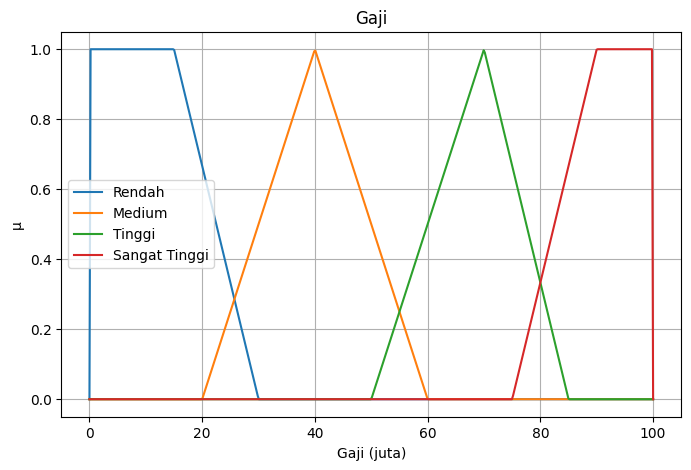

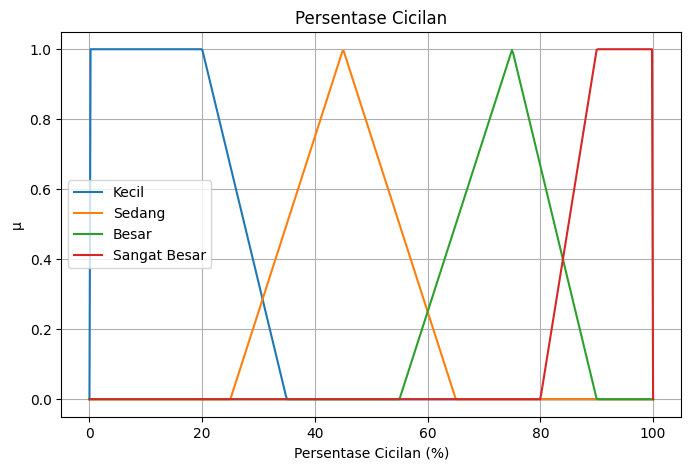

In [13]:
plot_gaji() # menampilan grafik gaji
print('\n')
plot_cicilan() # menampilkan grafik cicilan

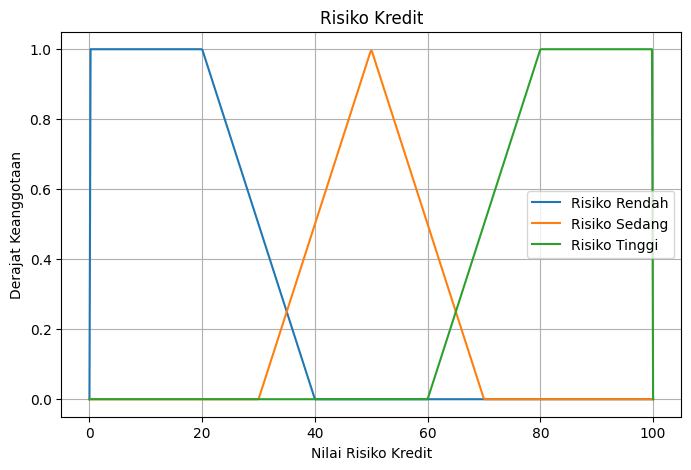


skala : 0 - 100


In [14]:
plot_resiko() # menampilkan grafik resiko
print('\nskala : 0 - 100') # memberikan keterangan untuk grafik resiko

In [15]:
print('baris = gaji \nkolom = persentase cicilan') # memberikan keterangan untuk tabel/matrix inferensi
df_matrix = tampilkan_rule_matrix() # menampilkan tabel/matrix inferensinya
df_matrix

baris = gaji 
kolom = persentase cicilan


,Kecil,Sedang,Besar,Sangat Besar
Rendah,Sedang,Tinggi,Tinggi,Tinggi
Medium,Rendah,Sedang,Tinggi,Tinggi
Tinggi,Rendah,Rendah,Sedang,Tinggi
Sangat Tinggi,Rendah,Rendah,Sedang,Sedang


In [16]:
print("    ------ 10 PENGAJU DENGAN RISIKO TERKECIL ------ ")
display(output) # menampilkan hasil untuk 10 orang yang memiliki resiko kredit paling rendah

print("\nFile peringkat excel berhasil dibuat")

    ------ 10 PENGAJU DENGAN RISIKO TERKECIL ------ 


,ID,Gaji,Persentase_Cicilan,Skor_Risiko_Kredit
49,50,30.0,4,15.607635
35,36,29.5,5,16.871969
15,16,28.0,8,20.098658
41,42,27.0,6,21.857051
29,30,26.5,7,22.638043
8,9,25.0,5,24.609068
19,20,24.0,10,25.643381
32,33,23.5,9,26.092208
45,46,22.5,11,26.870977
2,3,22.0,10,27.207662



File peringkat excel berhasil dibuat
